### Performing PCA on vectors with NaNs
This notebook demonstrates the use of numpy arrays as the content of RDDs

The reason that we use numpy arrays instead of dataframes is that numpy is better in handling `nan` etries.

In numpy `5+nan=5` while in dataframes `5+nan=nan`

Suppose that the data vectors are the column vectors denoted $x$ then the covariance matrix is defined to be
$$
E(x x^T)-E(x)E(x)^T
$$

Where $x x^T$ is the **outer product** of $x$ with itself.

If the data that we have is $x_1,x_2,x_n$ then the estimates we use are:
$$
\hat{E}(x x^T) = \frac{1}{n} \sum_{i=1}^n x_i x_i^T,\;\;\;\;\;
\hat{E}(x) = \frac{1}{n} \sum_{i=1}^n x_i
$$

As it happens, we often get vectors $x$ in which some, but not all, of the entries are `nan`. In such cases we sum the elements that are defined and keep a seperate counter for each entry.

In [1]:
import numpy as np

def outerProduct(X):
  """Computer outer product and indicate which locations in matrix are undefined"""
  O=np.outer(X,X)
  N=1-np.isnan(O)
  return (O,N)
def sumWithNan(M1,M2):
  """Add two pairs of matrix,count"""
  (X1,N1)=M1
  (X2,N2)=M2
  N=N1+N2
  X=np.nansum(np.dstack((X1,X2)),axis=2)
  return (X,N)
  

In [15]:
# computeCov recieves as input an RDD of np arrays, all of the same length, and computes the covariance matrix for that set of vectors
def computeCov(RDDin):
  RDD=RDDin.map(lambda v:np.insert(v,0,1)) # insert a 1 at the beginning of each vector so that the same 
                                           #calculation also yields the mean vector
  OuterRDD=RDD.map(outerProduct)   # separating the map and the reduce does not matter because of Spark uses lazy execution.
  (S,N)=OuterRDD.reduce(sumWithNan)
  # Unpack result and compute the covariance matrix
  #print 'RDD=',RDD.collect()
  print 'shape of S=',S.shape,'shape of N=',N.shape
  #print 'S=',S
  #print 'N=',N
  E=S[0,1:]
  NE=N[0,1:]
  print 'shape of E=',E.shape,'shape of NE=',NE.shape
  Mean=E/NE
  O=S[1:,1:]
  NO=N[1:,1:]+0.00001 # adding a small number to avoid 0/0
  Cov=O/NO - np.outer(Mean,Mean)
  return Cov,Mean

#### Demonstration on a small example

In [4]:
from pyspark import SparkContext

sc = SparkContext(master=master_url)

In [9]:
A=np.array([1,2,3,4,np.nan,5,6])
B=np.array([2,np.nan,1,1,1,1,1])
np.nansum(np.dstack((A,B)),axis=2)

array([[ 3.,  2.,  4.,  5.,  1.,  6.,  7.]])

In [13]:
RDD=sc.parallelize([A,B])

In [16]:
computeCov(RDD)

shape of S= (8, 8) shape of N= (8, 8)
shape of E= (7,) shape of NE= (7,)


(array([[  2.49987500e-01,  -1.00002000e+00,  -5.00012500e-01,
          -7.50015000e-01,   4.99980000e-01,  -1.00001750e+00,
          -1.25002000e+00],
        [ -1.00002000e+00,  -3.99996000e-05,   1.99994000e+00,
           2.99992000e+00,  -2.00000000e+00,   3.99990000e+00,
           4.99988000e+00],
        [ -5.00012500e-01,   1.99994000e+00,   9.99975000e-01,
           1.49996750e+00,  -1.00001000e+00,   1.99996000e+00,
           2.49995250e+00],
        [ -7.50015000e-01,   2.99992000e+00,   1.49996750e+00,
           2.24995750e+00,  -1.50001000e+00,   2.99994750e+00,
           3.74993750e+00],
        [  4.99980000e-01,  -2.00000000e+00,  -1.00001000e+00,
          -1.50001000e+00,  -9.99990000e-06,  -2.00001000e+00,
          -2.50001000e+00],
        [ -1.00001750e+00,   3.99990000e+00,   1.99996000e+00,
           2.99994750e+00,  -2.00001000e+00,   3.99993500e+00,
           4.99992250e+00],
        [ -1.25002000e+00,   4.99988000e+00,   2.49995250e+00,
           3.

## Reading from S3 using the spark-notebook server.
#### Set AWS Credentials

To access a S3 bucket, the first step is to set AWS credential. There are two ways to do it.

1. (**RECOMMENDED**) Set S3 credentials via Spark Notebook interface.
2. Set it using the `set_credential` method:
```python
s3helper.set_credential(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)
```

In [18]:
bucket='mas-dse-public'
dir='/home/ec2-user/spark/'
s3helper.open_bucket(bucket)

In [21]:
from time import time
t=time()
files = s3helper.s3_to_hdfs('/Weather/US_Weather.parquet', '/US_Weather.parquet')
print 'copying took',time()-t,'seconds'
## copying took 62.695912838 seconds

cp: `/US_Weather.parquet/_SUCCESS': File exists
cp: `/US_Weather.parquet/_common_metadata': File exists
cp: `/US_Weather.parquet/_metadata': File exists
cp: `/US_Weather.parquet/part-r-00000-0f4998c0-b27b-4f60-ad45-ed3212ddb46f.gz.parquet': File exists
cp: `/US_Weather.parquet/part-r-00001-0f4998c0-b27b-4f60-ad45-ed3212ddb46f.gz.parquet': File exists
cp: `/US_Weather.parquet/part-r-00002-0f4998c0-b27b-4f60-ad45-ed3212ddb46f.gz.parquet': File exists
cp: `/US_Weather.parquet/part-r-00003-0f4998c0-b27b-4f60-ad45-ed3212ddb46f.gz.parquet': File exists
cp: `/US_Weather.parquet/part-r-00004-0f4998c0-b27b-4f60-ad45-ed3212ddb46f.gz.parquet': File exists
cp: `/US_Weather.parquet/part-r-00005-0f4998c0-b27b-4f60-ad45-ed3212ddb46f.gz.parquet': File exists
cp: `/US_Weather.parquet/part-r-00006-0f4998c0-b27b-4f60-ad45-ed3212ddb46f.gz.parquet': File exists
cp: `/US_Weather.parquet/part-r-00007-0f4998c0-b27b-4f60-ad45-ed3212ddb46f.gz.parquet': File exists
cp: `/US_Weather.parquet/part-r-00008-0f4998c0-

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

In [23]:
t=time()
TMAX = sqlContext.sql("SELECT * FROM parquet.`/US_Weather.parquet` where measurement = 'TMAX'")
print 'took ',time()-t,' seconds'

took  1.51164889336  seconds


### Reading from s3 on databricks

```python
%run /Users/yfreund@ucsd.edu/Vault

AWS_BUCKET_NAME = "mas-dse-public" 
MOUNT_NAME = "NCDC-weather"
dbutils.fs.unmount("/mnt/%s" % MOUNT_NAME)
output_code=dbutils.fs.mount("s3n://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, AWS_BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
print 'Mount output status=',output_code
file_list=dbutils.fs.ls('/mnt/%s/Weather'%MOUNT_NAME)
file_list

US_Weather_parquet='/mnt/NCDC-weather/Weather/US_Weather.parquet/'
df = sqlContext.sql("SELECT * FROM  parquet.`%s`  where measurement=='TMAX'"%US_Weather_parquet)
df.show(5)
```

#### Demonstration on real data
The following cells demonstrate the use of the code we wrote on the maximal-dayly temperature records for the state of california.

In [24]:
print type(TMAX)
print TMAX.count()

<class 'pyspark.sql.dataframe.DataFrame'>
662767


In [48]:
# We transform the dataframe into an RDD of numpy arrays
# remove the entries that do not correspond to temperature and devide by 10 so that the result is in centigrates.
t=time()
rdd=TMAX.rdd.map(lambda v:np.array(v[3:-4])/10).cache()
print 'took ',time()-t,' seconds'

took  0.00815391540527  seconds


In [49]:
t=time()
print rdd.count()   #takes almost no time without this count() command (only plan is created)
print  'first time took ',time()-t,' seconds'

662767
first time took  20.5152611732  seconds


In [50]:
t=time()
print rdd.count()   #takes almost no time without this count() command (only plan is created)
print  'second time took ',time()-t,' seconds'

662767
second time took  0.284214019775  seconds


In [51]:
rows=rdd.take(5)
len(rows[1])

365

In [52]:
t=time()
UnDef=rdd.map(lambda row:sum(np.isnan(row))).collect()
print  'took ',time()-t,' seconds'

took  1.13223981857  seconds


Populating the interactive namespace from numpy and matplotlib


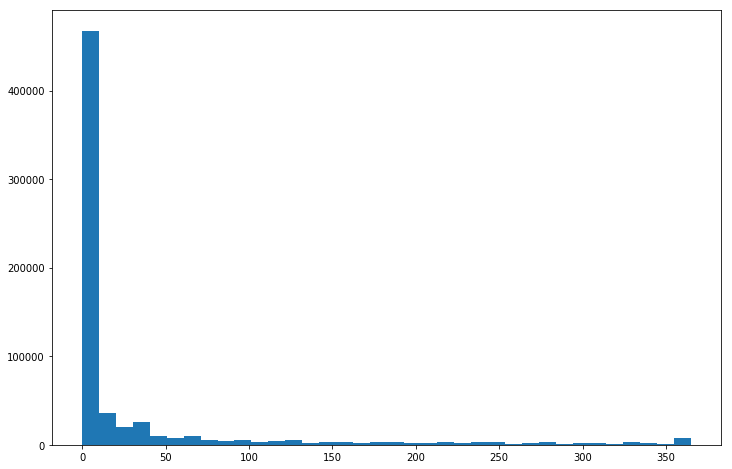

In [53]:
#import matplotlib.pyplot as plt
%pylab inline
figure(figsize=[12,8])
hist(UnDef,bins=36);

In [59]:
# Remove entries that have 50 or more nan's
thr=50
rdd1=rdd.filter(lambda row:sum(np.isnan(row))<thr)
print 'Original size is:%d, size after removing rows with %d or more nans: %d'%(rdd.count(),thr,rdd1.count())

Original size is:662767, size after removing rows with 50 or more nans: 558427


In [60]:
rdd1.first()

array([  0. ,   0. ,   0. ,   0.6,   4.4,   5. ,  13.3,   7.8,   5. ,
         3.3,   3.3,   6.7,   6.7,   5.6,   9.4,   7.8,   8.3,  12.2,
        11.7,   4.4,   3.9,   0. ,  11.1,  -0.6,   2.8,   3.9,   1.7,
         3.3,   0. ,  -2.2,   0. ,   3.3,   3.3,   0.6,   0.6,   0.6,
        12.2,   4.4,   4.4,   2.8,   0. ,   6.1,   9.4,   8.9,   6.1,
        11.1,  10.6,   6.1,   3.3,   4.4,  11.1,  10. ,  10.6,  12.2,
        12.2,  11.7,   6.1,  -0.6,   3.3,   2.2,   6.7,   4.4,   5. ,
         5. ,   2.8,   4.4,   5.6,   6.7,   7.2,   7.8,   6.7,  10.6,
        11.1,  10. ,  10. ,   8.9,   6.7,   9.4,  10. ,   8.3,   9.4,
        10. ,  11.1,  16.7,  13.9,   5.6,  11.1,   6.7,   4.4,  11.1,
        11.7,  12.2,   7.2,  13.3,   9.4,  11.1,  12.8,  22.2,  20.6,
        20. ,  13.9,  20.6,  15.6,  18.3,  18.3,  21.7,  19.4,  22.2,
        28.3,  28.3,  21.1,  13.9,  23.3,  20. ,  33.3,  29.4,  32.8,
        27.2,  21.7,  12.2,  15. ,  18.9,  20.6,  12.8,  14.4,  23.3,
        22.2,  25.6,

## compute covariance

In [61]:
t=time()
OUT=computeCov(rdd)
OUT
print 'took',time()-t, 'seconds'

shape of S= (366, 366) shape of N= (366, 366)
shape of E= (365,) shape of NE= (365,)
took 109.121930838 seconds


In [63]:
(Cov,Mean)=OUT

In [64]:
Cov[:10,:10]

array([[  95.04928215,   80.54064783,   71.41541364,   68.26263966,
          66.17589646,   64.53321989,   64.77031154,   64.45993193,
          64.4059323 ,   63.14433903],
       [  80.54064783,   95.06715081,   81.38666594,   72.43939477,
          68.06183576,   65.24471404,   65.0118917 ,   64.6272114 ,
          64.71815504,   62.65874998],
       [  71.41541364,   81.38666594,   96.4038978 ,   83.96482428,
          74.12825733,   68.40696927,   66.47500083,   65.36989735,
          65.79228738,   63.2800448 ],
       [  68.26263966,   72.43939477,   83.96482428,   98.20212537,
          85.13896741,   74.39557103,   69.91059316,   67.40898313,
          67.61227804,   65.44084122],
       [  66.17589646,   68.06183576,   74.12825733,   85.13896741,
          99.22642535,   84.72835032,   76.00487767,   71.67119658,
          70.09159591,   67.87805268],
       [  64.53321989,   65.24471404,   68.40696927,   74.39557103,
          84.72835032,   98.72842862,   85.98508242,   76

In [65]:
from numpy import linalg as LA
w,v=LA.eig(Cov)

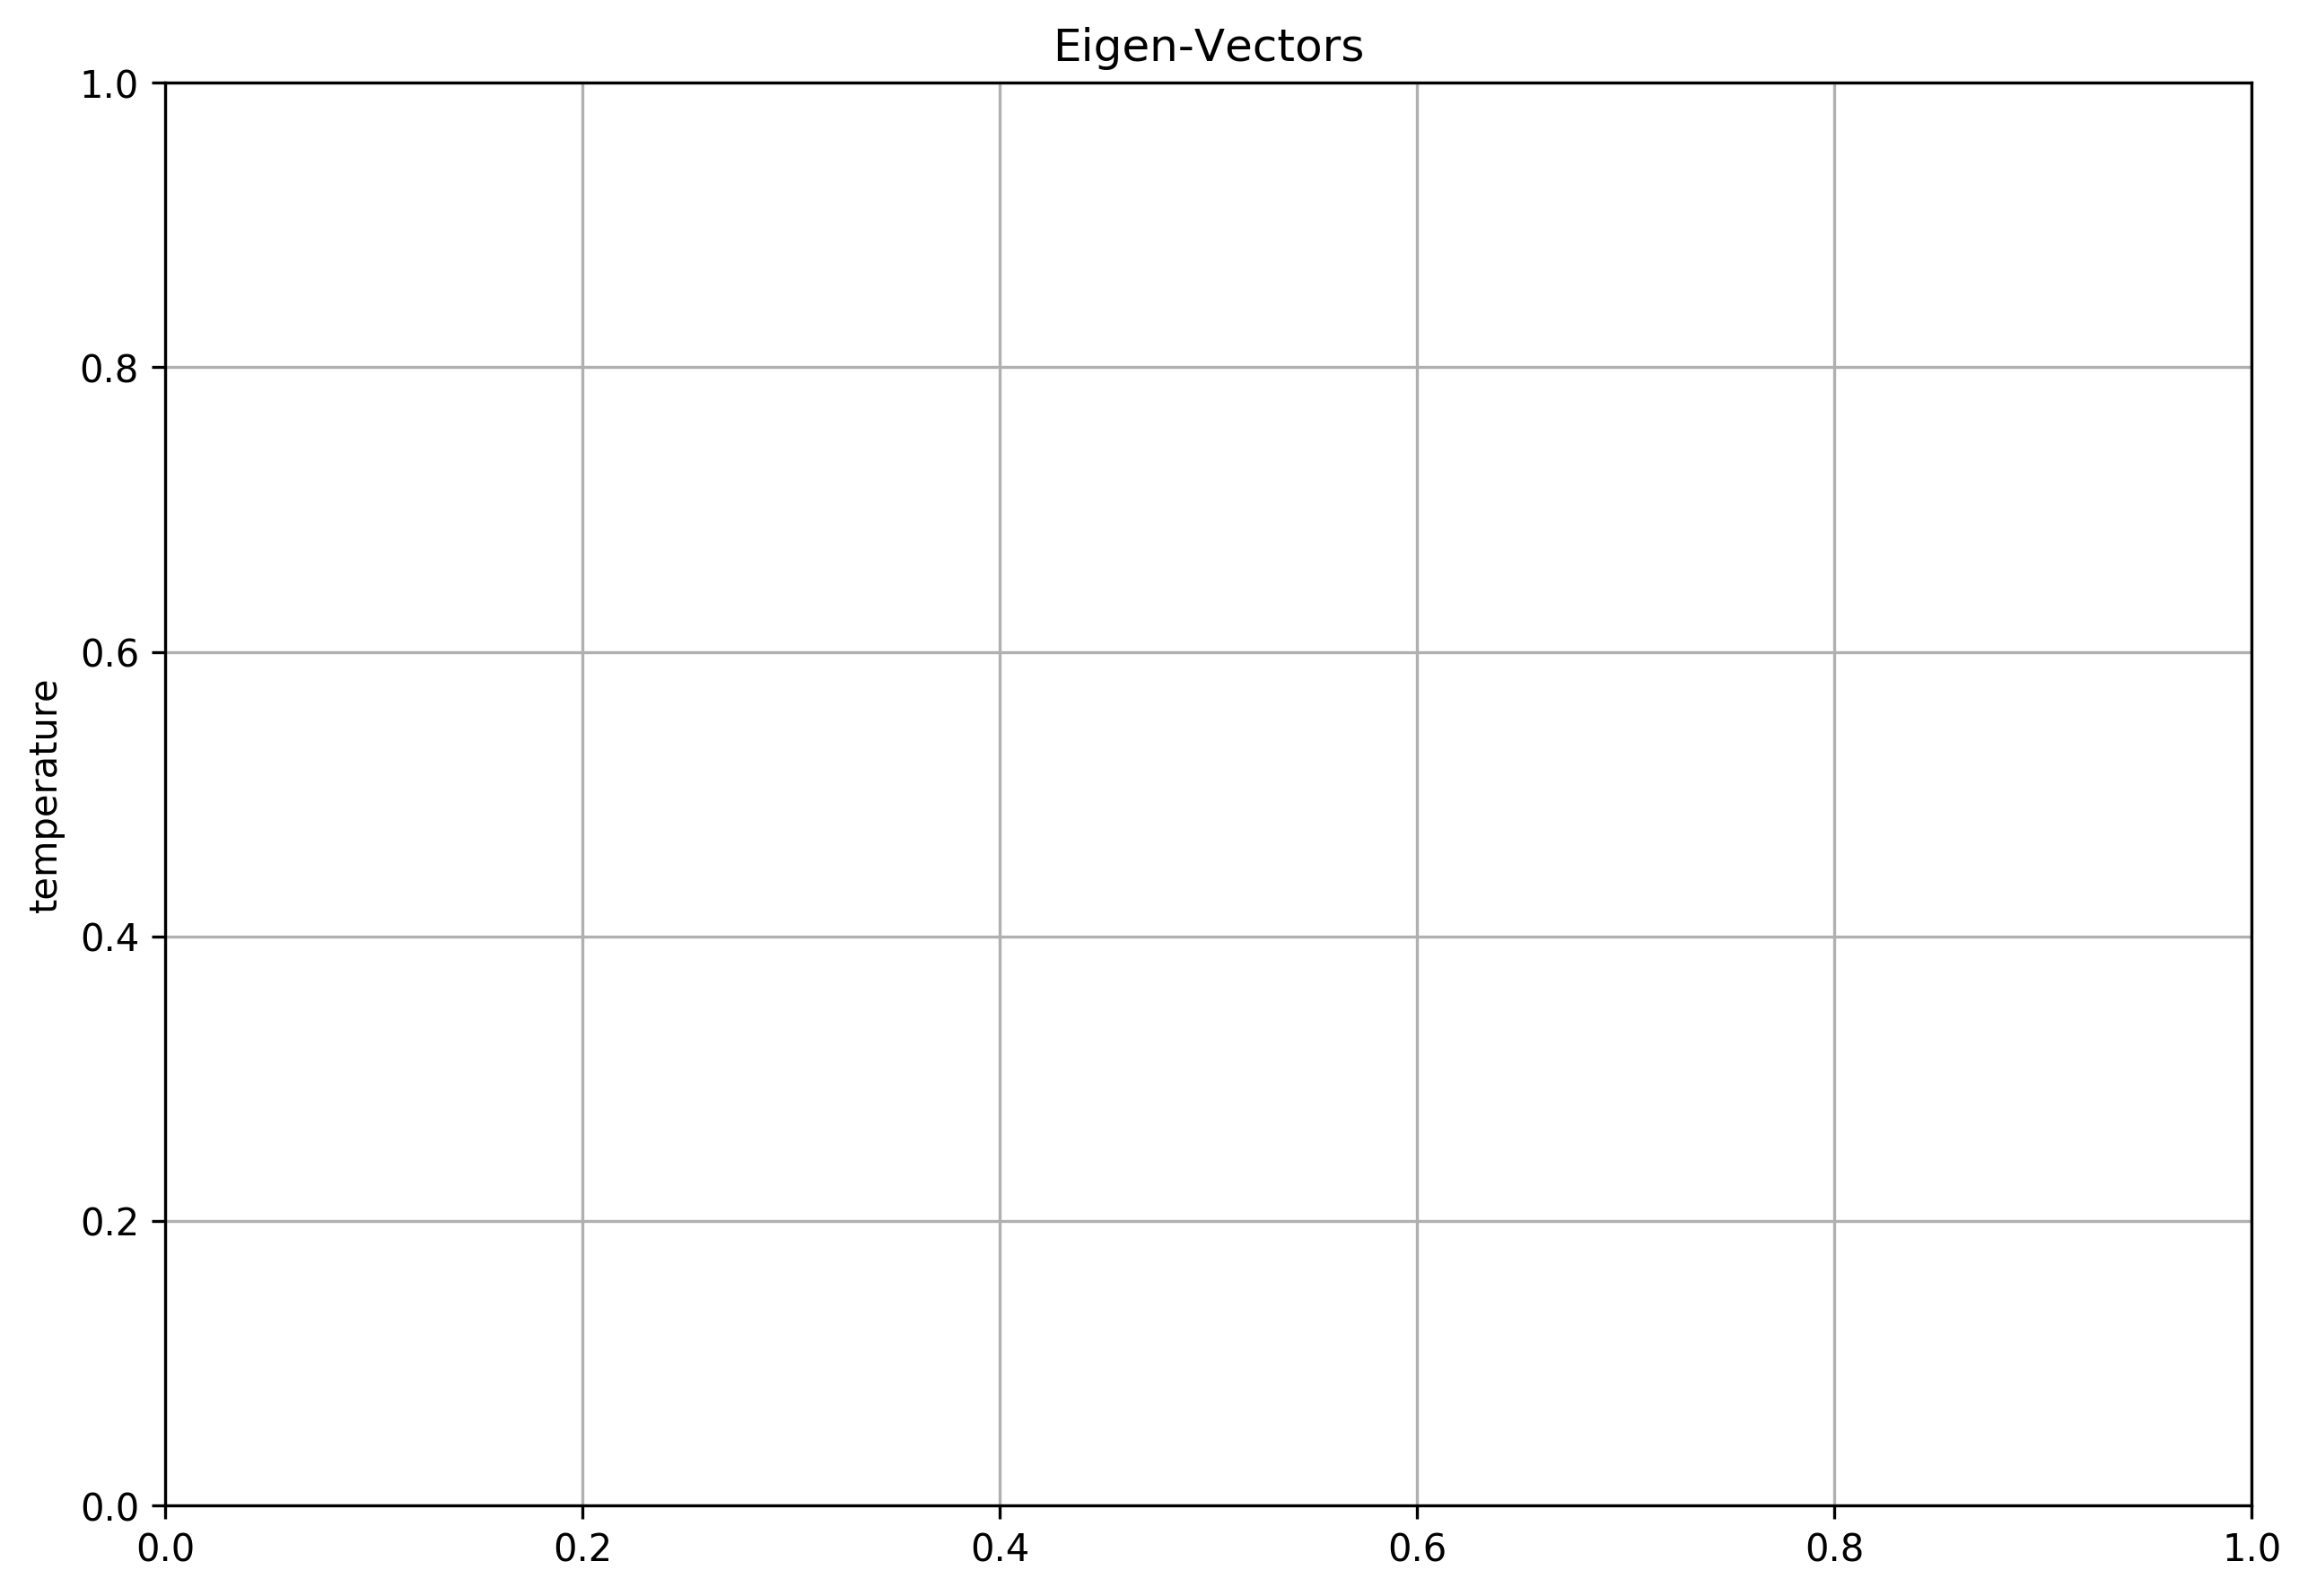

In [69]:
from datetime import date
from numpy import shape
import matplotlib.pyplot as plt
import pylab as py
from pylab import ylabel,grid,title

dates=[date.fromordinal(i) for i in range(1,366)]
def YearlyPlots(T,ttl='',size=(10,7)):
    fig=plt.figure(1,figsize=size,dpi=300)
    #fig, ax = plt.subplots(1)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    ax.plot(dates,T);
    # rotate and align the tick labels so they look better
    #fig.autofmt_xdate()
    ylabel('temperature')
    grid()
    title(ttl)
    return
fig=YearlyPlots(v[:,:4],'Eigen-Vectors')

In [26]:
fig=YearlyPlots(Mean,'Mean')
display(fig)

In [27]:
Var=np.cumsum(w)
Var=Var/Var[-1]
fig, ax = plt.subplots()
#ax.plot(x, Mean, 'r')
ax.plot(x,Var)
ax.grid()
display(fig)